In [1]:
# Import modules
import sys
sys.path.append("../code/")
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchviz import make_dot

from swag import SWAG
from models import SimpleNet, ConvNN, Classification_relu, Classification_sigmoid, Classification_tanh
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights, plot_decision_boundary
from data_gen import ClassificationDataSet

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imshow', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Classification on CIFAR10

The paper claims that the test accuracies of SWAG on the several image datasets typically outperforms all the baseline models in terms of accuracy.

In the below section, we will train a model on the dataset CIFAR-10. The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms:
1. It contains 60,000 32x32 color images in 10 different classes. 
2. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 
3. There are 6000 images of each class.

We split the dataset into training and testing set, where the training set contrains 50000 images and the test set contains 10000 images.

Due to the computational power limit, we are going to train a Simple Convolutional Neural network with the following architecture.

## Model Architechture

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Load train-test data

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((40, 40)),       
    transforms.RandomCrop((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=3,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


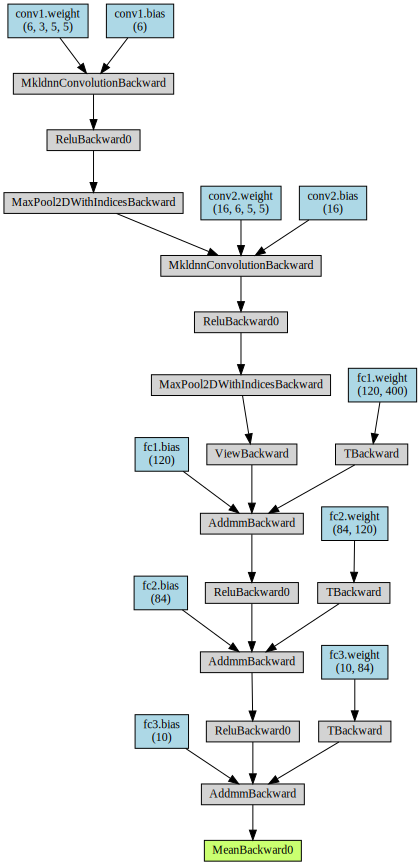

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
y = net(images)
make_dot(y.mean(),params = dict(net.named_parameters()))

### Loss function and optmizer

In [6]:
# Use the Classification Cross-Entropy loss and Adam optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(40, 40), interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(32, 32), padding=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([7, 8, 2])
horse  ship  bird


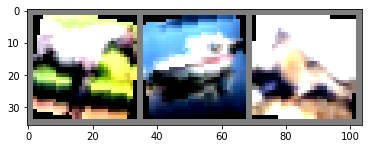

In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print labels
print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range(3)))
# show images
imshow(torchvision.utils.make_grid(images))

## Training without SWAG

### Training the model

In [9]:
def data_train(model= net, epoch = 2, model_path = '', optimizer = optimizer, criterion = criterion,trainloader = trainloader,batch = 2000):
    for epoch in range(epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % batch == (batch-1):    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / batch))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(model.state_dict(), model_path)
    print('Saved model parameters to disk.')
    

In [10]:
import os

model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    data_train(net,3,model_path)

Loaded model parameters from disk.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


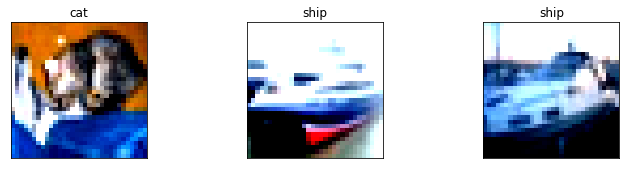

In [11]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Test Accuracy

In [12]:
def test_accuracy(model, testloader = testloader, classes = classes):
    # Overall accuracy on
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([len(classes),len(classes)], int)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))
    return confusion_matrix, model_accuracy

In [13]:
confusion_matrix,acc = test_accuracy(net)

Model accuracy on 10000 test images: 53.07%


In [14]:
def accuracy_class(cm):
    # On different categories
    print('{0:10s} - {1}'.format('Category','Accuracy'))
    for i, r in enumerate(cm):
        print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

In [15]:
accuracy_class(confusion_matrix)

Category   - Accuracy
plane      - 51.1
car        - 76.4
bird       - 27.1
cat        - 37.5
deer       - 41.9
dog        - 27.6
frog       - 75.3
horse      - 63.8
ship       - 70.2
truck      - 59.8


## Swag

In [16]:
swag = SWAG(Net, 3, True, net)

/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [17]:
# Compile swa
objective = 'classification'
lr = 1e-3
momentum=0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR

swag.compile(objective, lr,1, momentum, optimizer, loss_fn, swa_scheduler)

In [18]:
model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/'
model_path = model_directory_path + 'cifar-10-cnn-swag-model.pt'
new_net = Net()
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
# Compile swa
objective = 'classification'
lr = 1e-3
momentum=0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR
swag.compile(objective, lr,1, momentum, optimizer, loss_fn, swa_scheduler)
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)
if os.path.isfile(model_path):
    # load trained model parameters from disk
    new_net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    # Fit swag
    first_mom, second_mom, D = swag.fit(trainloader,
                                        train_epoch=0,
                                        swag_epoch=5,
                                        log_freq=4000,
                                        pretrained = True)
    # Test prediction
    # Test prediction
    testiter = iter(testloader)
    X_test, y_test = testiter.next()
    params_1d, shape_lookup, len_lookup = model_param_to_1D(net)
    model_params = params_1d_to_weights(first_mom, shape_lookup, len_lookup)
    new_net = create_NN_with_weights(Net, model_params)
    torch.save(new_net.state_dict(), model_path)

Loaded model parameters from disk.


In [19]:
# Overall accuracy
confusion_matrix_swag,_ = test_accuracy(new_net)

Model accuracy on 10000 test images: 57.20%


In [20]:
accuracy_class(confusion_matrix_swag)

Category   - Accuracy
plane      - 51.7
car        - 74.5
bird       - 32.0
cat        - 21.7
deer       - 39.7
dog        - 50.9
frog       - 82.5
horse      - 66.6
ship       - 80.6
truck      - 71.8


From the above results, we trained 3 epochs on our simple CNN models and got overall accuracy of 53.07% on the test set classification task. After that, we used the weights of the trained network as initial value of the SWAG weights and performed swag algorithm for 5 epochs. We see that the accuracy has increased around 4% to 57.20%. Indeed, the SWAG algorithm is capable of outperforming the baseline model in terms of accuracy in this case.

## Improvement on better models

From the above experiment, we verify that SWAG algorithm is capable of outperforming the baseline model in terms of accuracy on a simple neural network model. We will train a model to only classify dogs and cats and see if SWAG is able to improve the performace of a model that has pretty good test accuracy.

### Write functions to choose only specific classes of CIFAR-10

In [21]:
# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset  = CIFAR10(root='./data', train=True , download=True)#, transform = transform_with_aug)
testset   = CIFAR10(root='./data', train=False, download=True)#, transform = transform_no_aug)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)   



class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Choose only cats (class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
cat_dog_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['cat']), get_class_i(x_train, y_train, classDict['dog'])],
        transform_with_aug
    )
cat_dog_testset  = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['cat']), get_class_i(x_test , y_test , classDict['dog'])],
        transform_no_aug
    )

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader   = DataLoader(cat_dog_trainset, batch_size=4, shuffle=True , **kwargs)
testsetLoader    = DataLoader(cat_dog_testset , batch_size=4, shuffle=False, **kwargs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 0, 1, 1])
  Dog   Cat   Dog   Dog


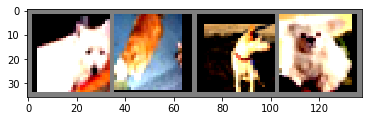

In [23]:
classes = ['Cat','Dog']
# get some random training images
dataiter = iter(trainsetLoader)
images, labels = dataiter.next()

# print labels
print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# show images
imshow(torchvision.utils.make_grid(images))

### Train the Model

### Model Architecture

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

### Define Training Procedure

In [25]:
def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [26]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

### Train the model and save weights

In [27]:
model = CNN()
model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/'
model_path = model_directory_path + 'cifar-10-cnn-catdog2-model.pt'
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)
if os.path.isfile(model_path):
    # load trained model parameters from disk
    model.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    device = torch.device("cpu") 
    losses = []
    accuracies = []
    for epoch in range(0, 20):
        losses.extend(train(model, device, trainsetLoader, optimizer, epoch))
        accuracies.append(test(model, device, trainsetLoader))
        torch.save(model.state_dict(), model_path)

Loaded model parameters from disk.


### Check accuracy on test set

In [28]:
confusion_matrix_catdog,_ = test_accuracy(model,testsetLoader,classes)

Model accuracy on 2000 test images: 84.45%


In [29]:
accuracy_class(confusion_matrix_catdog)

Category   - Accuracy
Cat        - 87.2
Dog        - 81.7


## SWAG

We've achieved a 84.45% accuracy on the test set classification, next we will apply the SWAG algorithm based on the above model

In [30]:
def train_swag(model, model_path):
    model_swag = CNN()
    swag = SWAG(CNN, 5, True, model)
    torch.manual_seed(seed)
    np.random.seed(seed)
    # Compile swa
    objective = 'classification'
    lr = 1e-3
    momentum=0.9
    optimizer = optim.SGD
    loss_fn = nn.CrossEntropyLoss()
    swa_scheduler = LambdaLR
    swag.compile(objective, lr,1, momentum, optimizer, loss_fn, swa_scheduler)
    if not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
    if os.path.isfile(model_path):
        # load trained model parameters from disk
        model_swag.load_state_dict(torch.load(model_path))
        print('Loaded model parameters from disk.')
    else:
        # Fit swag
        first_mom, second_mom, D = swag.fit(trainsetLoader,
                                            train_epoch=0,
                                            swag_epoch=5,
                                            log_freq=500,
                                            pretrained = True)
        # Test prediction
        testiter = iter(testsetLoader)
        X_test, y_test = testiter.next()
        params_1d, shape_lookup, len_lookup = model_param_to_1D(model)
        model_params = params_1d_to_weights(first_mom, shape_lookup, len_lookup)
        model_swag = create_NN_with_weights(CNN, model_params)
        torch.save(model_swag.state_dict(), model_path)
    return model_swag,swag

In [31]:
model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/Swag/'
model_path = model_directory_path + 'model_swag0.pt'
model_swag,swag = train_swag(model, model_path)

Loaded model parameters from disk.


In [32]:
classes = ['Cat','Dog']
confusion_matrix_catdog_swag,_ = test_accuracy(model_swag,testsetLoader,classes)

Model accuracy on 2000 test images: 85.80%


In [33]:
accuracy_class(confusion_matrix_catdog_swag)

Category   - Accuracy
Cat        - 85.3
Dog        - 86.3


## Average Accuracy

Since SWAG algorithm involves randomess, I will perform SWAG algorithm on the original model 10 times and calculate the average test accuracy on those models.

In [34]:
Swag_models = []
Swag_models.append(model_swag)
for i in range(1,10):
    model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/Swag/'
    model_path = model_directory_path + 'model_swag'+ str(i) + '.pt'
    model_swag,swag = train_swag(model, model_path)
    Swag_models.append(model_swag)

Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.


In [35]:
Swag_models[2]

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [36]:
Acc_swag = []
for i in range(10):
    _,acc= test_accuracy(Swag_models[i],testsetLoader,classes)
    Acc_swag.append(acc)

Model accuracy on 2000 test images: 85.80%
Model accuracy on 2000 test images: 85.60%
Model accuracy on 2000 test images: 86.15%
Model accuracy on 2000 test images: 85.35%
Model accuracy on 2000 test images: 85.60%
Model accuracy on 2000 test images: 85.25%
Model accuracy on 2000 test images: 84.20%
Model accuracy on 2000 test images: 85.00%
Model accuracy on 2000 test images: 85.40%
Model accuracy on 2000 test images: 84.95%


In [37]:
np.mean(Acc_swag)

85.33

## Ensemble of NN

In order to make the above results comparable, we will also perform an ensemble of the CNN model (consisting of 10 CNN with different initializations but same architecture) and compute the average classificaiton accuracy on the test set.

In [38]:
model_sample = model

In [39]:
CNN_models = []
CNN_models.append(model)
for i in range(1,10):
    #params_1d, shape_lookup, len_lookup = model_param_to_1D(model_sample)
    # Initialize parameters
    #n = len(params_1d)
    #init_p = np.random.normal(0, np.sqrt(1),n)
    #model_params = params_1d_to_weights(init_p, shape_lookup, len_lookup)
    #model_cnn = create_NN_with_weights(CNN, model_params)
    model_cnn = CNN()
    model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/CNN/'
    model_path = model_directory_path + 'model_CNN'+ str(i) + '.pt'
    if not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
    if os.path.isfile(model_path):
        # load trained model parameters from disk
        model_cnn.load_state_dict(torch.load(model_path))
        print('Loaded model parameters from disk.')
    else:
        optimizer = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)
        device = torch.device("cpu") 
        losses = []
        accuracies = []
        for epoch in range(0, 20):
            losses.extend(train(model_cnn, device, trainsetLoader, optimizer, epoch))
            accuracies.append(test(model_cnn, device, trainsetLoader))
        torch.save(model_cnn.state_dict(), model_path)
    CNN_models.append(model_cnn)

Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.


In [40]:
Acc_CNN = []
for i in range(10):
    _,acc= test_accuracy(CNN_models[i],testsetLoader,classes)
    Acc_CNN.append(acc)

Model accuracy on 2000 test images: 84.45%
Model accuracy on 2000 test images: 79.75%
Model accuracy on 2000 test images: 82.80%
Model accuracy on 2000 test images: 81.70%
Model accuracy on 2000 test images: 83.80%
Model accuracy on 2000 test images: 82.55%
Model accuracy on 2000 test images: 82.35%
Model accuracy on 2000 test images: 82.55%
Model accuracy on 2000 test images: 83.40%
Model accuracy on 2000 test images: 83.55%


In [41]:
np.mean(Acc_CNN)

82.69

From the above resuls. By comparing the test accuracy of models calculated by the SWAG algorithm and the average of 10 ensemble models with different initialization weights. We see that:
1. Average test accuracy of SWAG model is 85.33% 
2. Average test accuracy of Ensemble models is 82.69%

As a result, We may believe that the SWAG algorithm is capable of outperforming the baseline model in terms of accuracy.

## SWAG Uncertainty 

What's more important is that we want to measure if the SWAG algorithm is able to help the model to detect the out-of-distribution samples. 

We will interpret the output of our Neural Network Model - the classification probability - as an indicator of the confidence of the model when it is classifying a specific data point. Specifically, we will only train the model on 2 categories of the image (e.g. when the probability is close to 0.5, we say that the model is not confident in classifying the data point as class 1 or 0).

After training the model via SWAG algorithm, we are able to draw sets of parameters and form a posterior distribution of the model. As a result, we will apply those models on a predefined set of test images (some of them are OOD samples) and check the classification probability again.

We will first fixed a test that contains both in-distribution samples and out-of-distribution samples. We will select 5 images from all different classes.

In [42]:
def test_sample(i):
    testset  = DatasetMaker([get_class_i(x_test , y_test , classDict[i])],
                            transform_no_aug)
    kwargs = {'num_workers': 2, 'pin_memory': False}

    # Create datasetLoaders from testset
    testsetLoader = DataLoader(testset, batch_size=5, shuffle=False, **kwargs)
    dataiter = iter(testsetLoader)
    images, labels = dataiter.next()
    return images,labels

In [43]:
# Fixed a test
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 
           'frog', 'horse', 'ship', 'truck')
images_ls = {}
label_ls = {}
for i in classes:
    images, labels = test_sample(i)
    images_ls[i] = images
    label_ls[i] = labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


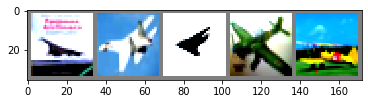

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


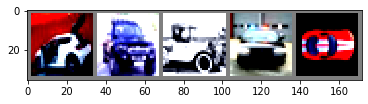

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


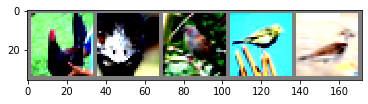

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


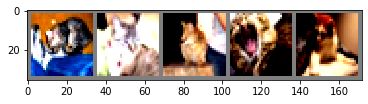

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


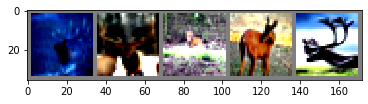

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


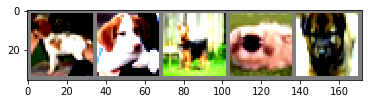

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


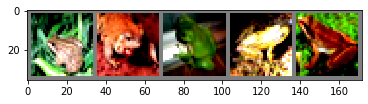

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


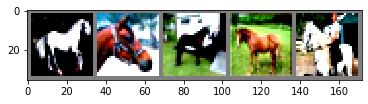

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


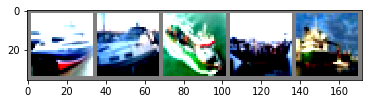

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


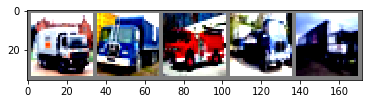

In [44]:
for i in classes:
    imshow(torchvision.utils.make_grid(images_ls[i]))

### Sample from SWAG Posterior Distribution

In [46]:
model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/Moments/'
model_path1 = model_directory_path + 'first_mom.npy'
model_path2 = model_directory_path + 'second_mom.npy'
model_path3 = model_directory_path + 'D.npy'

# Initalize the swag
model_swag = CNN()
swag = SWAG(CNN, 5, True, model)

if not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
if os.path.isfile(model_path1):
    # load trained model parameters from disk
    first_mom = np.load(model_path1)
    swag.first_mom = first_mom
    print('Loaded first_mom from disk.')
if os.path.isfile(model_path2):
    # load trained model parameters from disk
    second_mom = np.load(model_path2)
    swag.second_mom = second_mom
if os.path.isfile(model_path3):
    # load trained model parameters from disk
    D = np.load(model_path3)
    swag.D = D
    print('Loaded model parameters from disk.')
else:
    torch.manual_seed(seed)
    np.random.seed(seed)
    # Compile swa
    objective = 'classification'
    lr = 1e-3
    momentum=0.9
    optimizer = optim.SGD
    loss_fn = nn.CrossEntropyLoss()
    swa_scheduler = LambdaLR
    swag.compile(objective, lr,1, momentum, optimizer, loss_fn, swa_scheduler)
    # Fit swag
    first_mom, second_mom, D = swag.fit(trainsetLoader,
                                        train_epoch=0,
                                        swag_epoch=5,
                                        log_freq=500,
                                        pretrained = True)
    np.save(model_path1, first_mom)
    np.save(model_path2, second_mom)
    np.save(model_path3, D)


Loaded first_mom from disk.
Begin NN model training...

Begin SWAG training...
[Epoch: 1, 	Iteration:   500] 	Training Loss: 0.3370
[Epoch: 1, 	Iteration:  1000] 	Training Loss: 0.3506
[Epoch: 1, 	Iteration:  1500] 	Training Loss: 0.3372
[Epoch: 1, 	Iteration:  2000] 	Training Loss: 0.3434
[Epoch: 1, 	Iteration:  2500] 	Training Loss: 0.3550
[Epoch: 2, 	Iteration:   500] 	Training Loss: 0.3293
[Epoch: 2, 	Iteration:  1000] 	Training Loss: 0.3401
[Epoch: 2, 	Iteration:  1500] 	Training Loss: 0.3230
[Epoch: 2, 	Iteration:  2000] 	Training Loss: 0.3526
[Epoch: 2, 	Iteration:  2500] 	Training Loss: 0.3378
[Epoch: 3, 	Iteration:   500] 	Training Loss: 0.3259
[Epoch: 3, 	Iteration:  1000] 	Training Loss: 0.3296
[Epoch: 3, 	Iteration:  1500] 	Training Loss: 0.3334
[Epoch: 3, 	Iteration:  2000] 	Training Loss: 0.3352
[Epoch: 3, 	Iteration:  2500] 	Training Loss: 0.3340
[Epoch: 4, 	Iteration:   500] 	Training Loss: 0.3061
[Epoch: 4, 	Iteration:  1000] 	Training Loss: 0.3198
[Epoch: 4, 	Iteratio

In [47]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
# Generate weight samples
S = 1000
weight_samples = []
for i in range(S):
    samples = swag.weight_sampler()
    weight_samples.append(samples)

# Recreate Models:
swag_models = []
for s, weight_param in enumerate(weight_samples):
    model_params = params_1d_to_weights(weight_param, swag.shape_lookup, swag.len_lookup)
    new_net = create_NN_with_weights(swag.NN_class, model_params)
    swag_models.append(new_net)

/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/code/util.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_params = torch.tensor(params_1d[pointer:pointer+length]).reshape(shape)


In [48]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
Prediction_var = {}
sm = torch.nn.Softmax()
for i in classes:
    data = images_ls[i]
    prediction_ls = []
    for j in swag_models:
        outputs=j(data)
        prob = sm(outputs) 
        Prediction = np.argmax(prob.detach().numpy(),axis = 1)
        prediction_ls.append(Prediction)
    Prediction_var[i] = np.var(prediction_ls,axis = 0)
        

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [49]:
Epistemic_df = pd.DataFrame.from_dict(Prediction_var)

In [50]:
np.mean(Epistemic_df)

plane    0.163743
car      0.192357
bird     0.127111
cat      0.134103
deer     0.168089
dog      0.144256
frog     0.150841
horse    0.162835
ship     0.133798
truck    0.186610
dtype: float64

In [51]:
sort_df = Epistemic_df[Epistemic_df.sum(0).sort_values(ascending=True).index]

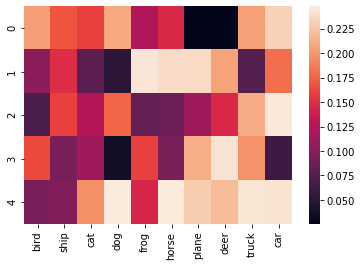

In [52]:
sns.heatmap(sort_df)

### More Images

In [53]:
# seed = 1
# torch.manual_seed(seed)
# np.random.seed(seed)
# # Fixed a test
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# images_ls = {}
# label_ls = {}
# for i in classes:
#     testset  = \
#         DatasetMaker(
#             [get_class_i(x_test , y_test , classDict[i])],
#             transform_no_aug
#         )

#     kwargs = {'num_workers': 2, 'pin_memory': False}

#     # Create datasetLoaders from trainset and testset
#     testsetLoader    = DataLoader(testset , batch_size=40, shuffle=True, **kwargs)
#     dataiter = iter(testsetLoader)
#     images, labels = dataiter.next()
#     images_ls[i] = images
#     label_ls[i] = labels
# Prediction_var = {}
# sm = torch.nn.Softmax()
# for i in classes:
#     data = images_ls[i]
#     prediction_ls = []
#     for j in swag_models:
#         outputs=j(data)
#         prob = sm(outputs) 
#         Prediction = np.argmax(prob.detach().numpy(),axis = 1)
#         prediction_ls.append(Prediction)
#     Prediction_var[i] = np.var(prediction_ls,axis = 0)

In [54]:
# Epistemic_df30 = pd.DataFrame.from_dict(Prediction_var)
# sort_df30 = Epistemic_df30[Epistemic_df30.sum(0).sort_values(ascending=True).index]

In [55]:
# sns.heatmap(sort_df30,cmap="YlGnBu")

### More advanced uncertainty estimation method

The above uncertainty measurement seems to only work when data have low dimension, in which we can eye ball the results. In this section, I will use a more advanced uncertainty estimation method from the paper "BaCOUn: Bayesian Classifers with Out-of-Distribution Uncertainty" (https://arxiv.org/pdf/2007.06096.pdf)

Ideally, we should expect to see higher epistemic uncertaintity for instances for held-out classes (classes other than cat and dog) compared to the uncertainty for in-distribution points. (class cat and dog). On the other hand, points from those held-out classes should also have comparable aleatoric uncertainty to in-distribution samples.

The paper states the following point: Given an ensemble of models (such as the models obtained by sampling from the posterior distribution over the parameters of a BNN), the entropy of the posterior predicted Categorical distribution is a measure of the total predictive uncertainty.
The total uncertainty can be further decomposed into: aleatoric uncertainty, arising due to noise, and epistemic uncertainty, arising due to lack of knowledge when no data are observed on a given region of the feature space. We can calculate the expected entropy at a given point by averaging the entropies of the Categorical distributions predicted by each member of the ensemble. This is a measure of aleatoric uncertainty in predicting a single point. Finally, the Mutual Information (MI) between the categorical label y and the pa- rameters of the model W (i.e. in deep learning models these are the weights of the network), calculated by subtracting the expected entropy from total entropy, is a measure of the spread of the ensemble, and in turn a measure of epistemic uncertainty.

Mathematcially, it can be expressed as following:

$$
\begin{aligned}
I(y,W\mid x^{*},D) &= \mathbb{H}[\mathbb{E}_{p(W\mid D)}[p(y\mid x^{*},W)]\\
&- \mathbb{E}_{p(W\mid D}[\mathbb{H}[p(y\mid x^{*},W]]\\
\end{aligned}
$$

In [56]:
def entropy(p):
    return -sum([p[i] * np.log(p[i]) for i in range(len(p))])

#### Total Uncertainty (Entropy of the predicted Categorical distribution)

In [57]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
Total_uncetainty = {i:None for i in classes}
sm = torch.nn.Softmax()
for i in classes:
    data = images_ls[i]
    for k in data:
        prob_sample = []
        avg_prob = []
        for j in swag_models:
            outputs=j(k.reshape(-1,3,32,32))
            prob = sm(outputs).detach().numpy()
            prob_sample.append(prob)
        avg_prob.append(np.mean(prob_sample,axis = 0))
    Total_uncetainty[i]=entropy(np.array(avg_prob))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [58]:
Total_uncetainty

{'plane': 0.67351097,
 'car': 0.67746246,
 'bird': 0.5495795,
 'cat': 0.61822236,
 'deer': 0.66428834,
 'dog': 0.6898838,
 'frog': 0.6156498,
 'horse': 0.691476,
 'ship': 0.5045874,
 'truck': 0.6908481}

#### Aleatoric uncertainty

In [59]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
Entropy_ind = {i:[] for i in classes}
Aleatoric_uncetainty = {i:None for i in classes}
sm = torch.nn.Softmax()
for i in classes:
    data = images_ls[i]
    for k in data:
        entro_sample = []
        for j in swag_models:
            outputs=j(k.reshape(-1,3,32,32))
            prob = sm(outputs).detach().numpy()
            entro = entropy(prob)
            entro_sample.append(entro)
        Entropy_ind[i].append(np.array(entro_sample))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [60]:
Aleatoric_uncetainty = {i:np.mean(Entropy_ind[i]) for i in classes}

In [61]:
Aleatoric_uncetainty

{'plane': 0.396947,
 'car': 0.4617724,
 'bird': 0.3567254,
 'cat': 0.38524932,
 'deer': 0.4708209,
 'dog': 0.35279906,
 'frog': 0.41072968,
 'horse': 0.4616059,
 'ship': 0.40194973,
 'truck': 0.46503505}

### Epistemic Uncertainty

In [62]:
Ep_uncertainty = {i:(Total_uncetainty[i] - Aleatoric_uncetainty[i]) for i in classes}

In [63]:
Ep_uncertainty

{'plane': 0.27656397,
 'car': 0.21569005,
 'bird': 0.1928541,
 'cat': 0.23297304,
 'deer': 0.19346744,
 'dog': 0.33708477,
 'frog': 0.20492014,
 'horse': 0.22987008,
 'ship': 0.10263768,
 'truck': 0.22581306}

From above, the results for epistemic uncertainty is definitely not ideal. (i.e. The epistemic uncertainteis for dog and cat are actually higher than that of other categories). There are seveal possible reasons that might result in the above observations:
1. The model is not complex enough to classify dogs and cats, since it only achieves around 85% test accuracy. A more complex and power might be more desirable.
2. We only apply the model on 5 samples for each category due to the computational limitation, more samples might generate different results.
3. The SWAG algorithm simply is not good enough to train a model to detect the OOD samples. It could also be the case that the model is highly sensitive to hyperparameters and fine tuning would be necessary to make the algorithm works.